**Importation of needed Libraries**

In [1]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Automatically created module for IPython interactive environment


**Dataset Importaion and Processing**

The dataset - lfw_people were imported from sklearn.datasets. The label to predict is the identity of the individuals in the image (image recognition).

In [2]:
# Downloading and loading the dataset as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)


# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


**Splitting data into a training set and a test set with test_size of 25%, and printing the resulting input variables X**

In [3]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_test.shape)
print(X_train.shape)

(322, 1850)
(966, 1850)


**Setting parameters for the learner (Random Forest Classifier), and predicting an output variable y**

In [4]:
from sklearn.ensemble import RandomForestClassifier

t = time()

#using 20 as number of estimators (tress in the forest), random_state is set at 0 to keep the data same at every run

clf = RandomForestClassifier(n_estimators=20, random_state=0)

clf.fit(X_train, y_train)

print("done in %0.3fs" % (time() - t))

y_pred = clf.predict(X_test)

done in 0.451s


**Quantitative evaluation of the model quality on the test set**

In [5]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.007s
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.23      0.32        13
     Colin Powell       0.63      0.67      0.65        60
  Donald Rumsfeld       0.50      0.33      0.40        27
    George W Bush       0.66      0.88      0.75       146
Gerhard Schroeder       0.70      0.28      0.40        25
      Hugo Chavez       0.67      0.53      0.59        15
       Tony Blair       0.47      0.25      0.33        36

         accuracy                           0.63       322
        macro avg       0.59      0.45      0.49       322
     weighted avg       0.62      0.63      0.60       322

[[  3   2   2   6   0   0   0]
 [  2  40   2  14   0   0   2]
 [  0   6   9   9   1   0   2]
 [  1   7   4 128   2   1   3]
 [  0   1   0  11   7   3   3]
 [  0   1   0   6   0   8   0]
 [  0   6   1  20   0   0   9]]


**Result: With the chosen parameters in the Random Forest Classifier, we have an accuracy of 63%.**

**Qualitative evaluation of the predictions using matplotlib**

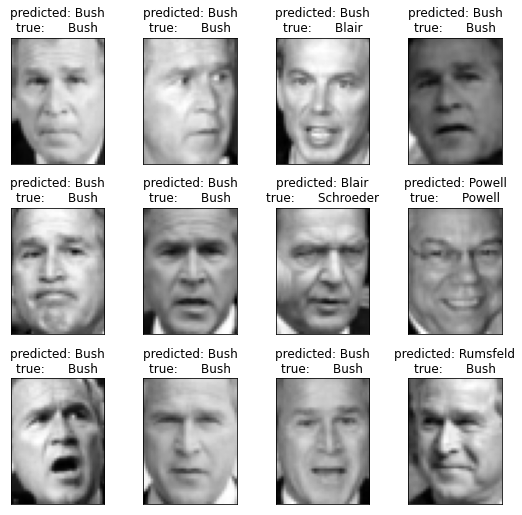

In [6]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)


plt.show()

The above plots show how the Learner predicted the images.

> **Including Principal Component Analysis (PCA) to reduce the dimensionality of the dataset, and Hyper-parameter to pick the optimal number of estimators**

In [7]:
#Feature extraction and dimensionality reduction

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")

t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.245s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.038s


Printing the reduced input variables X

In [8]:
print(X_test_pca.shape)

print(X_train_pca.shape)

(322, 150)
(966, 150)


**Finding the optimal number of n_estimators using hyper-parameter**

In [9]:
#NOTE: This cell was changed to Markdown cell type when running setting the number of estimators manually

t0 = time()

param_grid = {'n_estimators': [10, 20, 50, 100, 500], 
             }

clf = GridSearchCV(
    RandomForestClassifier(random_state=0), param_grid)

clf.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))

y_pred = clf.predict(X_test_pca)

print(clf.best_estimator_)

done in 23.037s
RandomForestClassifier(n_estimators=20, random_state=0)


**Quantitative evaluation of the model quality on the test set**

In [10]:
print("Predicting people's names on the test set")
t0 = time()

y_pred = clf.predict(X_test_pca)

print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.007s
                   precision    recall  f1-score   support

     Ariel Sharon       0.33      0.08      0.12        13
     Colin Powell       0.51      0.48      0.50        60
  Donald Rumsfeld       0.42      0.19      0.26        27
    George W Bush       0.58      0.92      0.71       146
Gerhard Schroeder       1.00      0.08      0.15        25
      Hugo Chavez       0.40      0.13      0.20        15
       Tony Blair       0.56      0.14      0.22        36

         accuracy                           0.56       322
        macro avg       0.54      0.29      0.31       322
     weighted avg       0.56      0.56      0.49       322

[[  1   3   3   6   0   0   0]
 [  0  29   3  27   0   0   1]
 [  0   5   5  17   0   0   0]
 [  1   5   1 135   0   2   2]
 [  1   5   0  16   2   1   0]
 [  0   5   0   7   0   2   1]
 [  0   5   0  26   0   0   5]]


The optimal no of estimators from the given estimators in the hyperparameter is 50.

> **The accuracy of the classifier reduced to 59%. Training and prediction also took more time (this is due to increase in number of estimators to 50).**

That means, PCA was not effective on the Random Forest Classifier for this dataset.